In [1]:
import proba_modules as pm
import numpy as np
from pyrocko import moment_tensor as mtm
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
reload(pm)

file_slopes = '../../../Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_curve = './test_data_Venus/GF_reverse_fault_1Hz_c15km.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, dist_min = 100., plot=False)

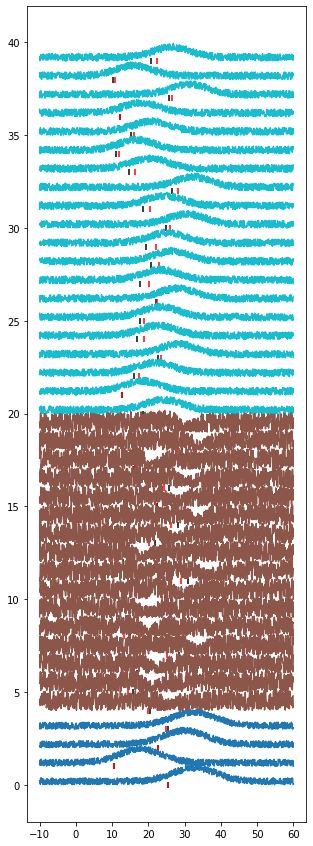

In [313]:
def extract_colors(cmap_name, n_colors):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 1, n_colors)]
    return colors

vel = 0.34
n_stations = 40
prop_clusters = [0.1, 0.4, 0.5]
t0 = 0.
std = 5.
max_pert = 10.
max_pert_std = 2
max_noise = 1.25
t = np.linspace(-10., 60., 1000)

np.random.seed(10)
model_arrival_time = lambda dist, t0, vel: t0 + dist/vel 
model_signal = lambda t, arrival_time, std, factor: factor*np.exp(-((t-arrival_time-std)/std)**2)-2*(1/std)*((t-arrival_time-std)/std)*np.exp(-((t-arrival_time-std)/std)**2)
dists = vel*10. + np.random.rand(n_stations)*vel*20.

id_clusters = []
coefs_clusters_time = (np.random.rand(len(prop_clusters))-0.5)*max_pert
coefs_clusters_std = (np.random.rand(len(prop_clusters))-0.5)*max_pert_std
coefs_clusters_noise = np.random.rand(len(prop_clusters))*max_noise
last_id = 0
all_ids = np.arange(n_stations)
for prop_cluster in prop_clusters:
    n_cluster = int(prop_cluster*n_stations)
    if prop_cluster == prop_clusters[-1]:
        n_cluster = n_stations
    id_clusters.append(all_ids[last_id:last_id+n_cluster])
    last_id = last_id+n_cluster

pert_arrival_times = np.zeros(n_stations)
pert_std = np.zeros(n_stations)
for icluster, ids in enumerate(id_clusters):
    factor_time = coefs_clusters_time[icluster]
    factor_std = coefs_clusters_std[icluster]
    for id in ids:
        pert_arrival_times[id] = np.random.rand()*factor_time
        pert_std[id] = factor_std
    
cmaplist = extract_colors('tab10', len(prop_clusters))
    
plt.figure(figsize=(5,15))
dt = t[1]-t[0]
itaper = int(20./dt)
signals = np.zeros((n_stations, t.size))
for icluster, ids in enumerate(id_clusters):
    color = cmaplist[icluster]
    for id in ids:
        
        arrival_time = model_arrival_time(dists[id], t0, vel)
        arrival_time_pert = pert_arrival_times[id] + arrival_time
        
        i_roll_pert = int(arrival_time_pert/dt)
        window_taper = np.zeros_like(signals[id,:])
        window_taper[i_roll:i_roll+itaper] = 1.
        
        #print(pert_std[id])
        noise = np.random.rand(signals.shape[1])*coefs_clusters_noise[icluster]
        signals[id,:] = abs(noise+model_signal(t, arrival_time_pert, std*(1+pert_std[id]), pert_std[id]))
        
        iwindow = int(t[-1]/dt)
        i_roll = -int(arrival_time/dt) + iwindow//2
       # plt.plot(t, id+np.roll(signals[id,:], i_roll), color=color)
        plt.plot(t, id+signals[id,:], color=color)
        plt.scatter(arrival_time_pert, id, marker='|', color='black')
        plt.scatter(arrival_time, id, marker='|', color='red')
        #print(i_roll_pert, itaper//2, signals[id,i_roll_pert-itaper//2:i_roll_pert+itaper//2].shape)
        #plt.plot(t[:min(i_roll_pert+itaper//2, t.size)-max(i_roll_pert-itaper//2,0)], id+signals[id,max(i_roll_pert-itaper//2,0):i_roll_pert+itaper//2], color=color)
        #plt.plot(t[i_roll:i_roll+itaper], id+np.roll(signals[id,:], i_roll), color='black', linestyle=':')
        

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:49: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


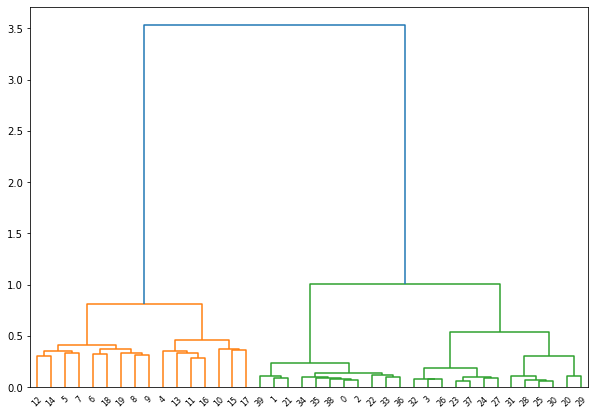

[3 3 3 4 2 1 1 1 1 1 2 2 1 2 1 2 2 2 1 1 4 3 3 4 4 4 4 4 4 4 4 4 4 3 3 3 3
 4 3 3]


In [317]:
n = len(signals)
cross_correlations_time = np.zeros((n, n))
cross_correlations_amp = np.ones((n, n))

offset_bad_solution = np.random.rand(n_stations)*3.

dt = t[1]-t[0]
iwindow = int((t[-1]-t[0])/dt)
itaper = int(20./dt)
for i in range(n):
    for j in range(i, n):
        if i == j:
            #cross_correlations_amp[i, j] = np.nan
            continue
        #    cross_correlations[i, j] = np.correlate(signals[i], signals[j], mode='full')
        #else:
        arrival_time_i = model_arrival_time(dists[i]+offset_bad_solution[i], t0, vel) 
        arrival_time_j = model_arrival_time(dists[j]+offset_bad_solution[j], t0, vel)
        i_roll = -int(arrival_time_i/dt) + iwindow//2
        j_roll = -int(arrival_time_j/dt) + iwindow//2
        window_taper_i = np.zeros_like(signals[id,:])
        beg, end = int(itaper*(1/4)), int(itaper*(3/4))
        #min_i, max_i = max(int(arrival_time_i/dt)-itaper//2, 0), min(int(arrival_time_i/dt)+itaper//2, t.size)
        min_i, max_i = int(arrival_time_i/dt)-beg, min(int(arrival_time_i/dt)+end, t.size)
        window_taper_i[min_i:max_i] = 1.
        window_taper_j = np.zeros_like(signals[id,:])
        #min_j, max_j = max(int(arrival_time_j/dt)-itaper//2, 0), min(int(arrival_time_j/dt)+itaper//2, t.size)
        min_j, max_j = int(arrival_time_j/dt-beg), min(int(arrival_time_j/dt)+end, t.size)
        window_taper_j[min_j:max_j] = 1.
        signali, signalj = np.roll(signals[i]*window_taper_i, i_roll), np.roll(signals[j]*window_taper_j, j_roll)
        #print(signali)
        cross_corr = np.correlate(signali/np.linalg.norm(signali), signalj/np.linalg.norm(signalj), mode='full')
        #print(cross_corr.argmax(), iwindow//2, cross_corr.size, t.size)
        norm_factor = 1.#np.linalg.norm(np.roll(signals[i], i_roll)) * np.linalg.norm(np.roll(signals[j], j_roll))
        cross_correlations_amp[i, j] = cross_corr.max()/norm_factor
        cross_correlations_amp[j, i] = cross_corr.max()/norm_factor  # Symmetric matrix
        cross_correlations_time[i, j] = (cross_corr.argmax()-iwindow//1)*dt
        cross_correlations_time[j, i] = (cross_corr.argmax()-iwindow//1)*dt  # Symmetric matrix
            
#plt.figure()
#plt.pcolormesh(cross_correlations_time)
#plt.pcolormesh(cross_correlations_amp, vmin=cross_correlations_amp[cross_correlations_amp>1].min())

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# Convert similarity to distance
dist_matrix = 1 - cross_correlations_amp

# Step 3: Apply hierarchical clustering
linked = linkage(dist_matrix, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=range(n))
plt.show()

# Form flat clusters (e.g., 0.7 is a threshold for the dendrogram)
clusters = fcluster(linked, 0.6, criterion='distance')

print(clusters)

0 --> 0.0
0 --> 0.07007007007007005
0 --> 0.0
0 --> 0.0
0 --> 5.325325325325323
0 --> 2.7327327327327318
0 --> 6.026026026026024
0 --> 1.471471471471471
0 --> 5.675675675675674
0 --> 3.5735735735735723
0 --> 7.847847847847845
0 --> 7.497497497497495
0 --> 1.611611611611611
0 --> 6.516516516516514
0 --> 3.223223223223222
0 --> 0.07007007007007005
0 --> 7.777777777777775
0 --> 7.497497497497495
0 --> 1.8218218218218212
0 --> 5.115115115115113
0 --> 2.802802802802802
0 --> 0.0
0 --> 0.0
0 --> 0.0
0 --> 0.0
0 --> 1.1911911911911908
0 --> 0.42042042042042027
0 --> 0.07007007007007005
0 --> 0.4904904904904903
0 --> 5.4654654654654635
0 --> 0.7707707707707705
0 --> 1.8918918918918912
0 --> 0.07007007007007005
0 --> 0.0
0 --> 0.0
0 --> 0.0
0 --> 0.0
0 --> 0.1401401401401401
0 --> 0.0
0 --> 0.0
--> 1 [2.73273273 2.94294294 2.52252252 2.87287287 3.15315315 2.87287287
 3.08308308 3.01301301 2.8028028 ]
--> 2 [5.32532533 4.97497497 5.11511512 5.95595596 5.46546547 4.9049049
 5.3953954 ]
--> 3 [0. 

Text(0.5, 1.0, '0.748 | 3.111')

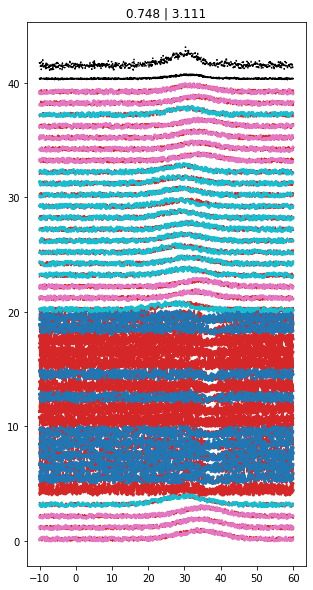

In [320]:
shifted_signals = np.zeros_like(signals)
time_correction = cross_correlations_time[0,:]
color='tab:red'
plt.figure(figsize=(5,10))
for id in range(n_stations):

    arrival_time = model_arrival_time(dists[id]+offset_bad_solution[id], t0, vel)-time_correction[id]
    iwindow = int(t[-1]/dt)
    i_roll = -int((arrival_time)/dt) + iwindow//2
    arrival_time = model_arrival_time(dists[id], t0, vel)
    i_roll_init = -int((arrival_time)/dt) + iwindow//2
    shifted_signals[id,:] = np.roll(signals[id,:], i_roll)
    plt.plot(t, id+shifted_signals[id,:], color=color)
    #plt.plot(t, id+np.roll(signals[id,:], i_roll_init), color=color, linestyle=':')
    print('0 -->', time_correction[id])
plt.plot(t, n_stations+shifted_signals.mean(axis=0), color='black')
#plt.title(shifted_signals.mean(axis=0).max())
max_base = shifted_signals.mean(axis=0).max()

cmaplist = extract_colors('tab10', len(np.unique(clusters)))
shifted_signals = 0.
#plt.figure(figsize=(5,10))
iwindow = int(t[-1]/dt)
all_clusters = np.unique(clusters)
for icluster in all_clusters:
    ids = np.where(clusters==icluster)[0]
    if len(ids) < 3:
        continue
    #ids = id_clusters[icluster-1]
    color = cmaplist[icluster-1]
    ref_stat_cluster = ids[0]
    if icluster == all_clusters[0]:
        time_correction_ref = cross_correlations_time[0,:]
    time_correction = cross_correlations_time[ref_stat_cluster,:]
    shifted_signals_loc = np.zeros_like(signals[id,:])
    for id in ids:
        #print(time_correction[id])
        arrival_time = model_arrival_time(dists[id]+offset_bad_solution[id], t0, vel)
        i_roll = -int((arrival_time-time_correction[id]-time_correction_ref[ref_stat_cluster])/dt) + iwindow//2
        #arrival_time = model_arrival_time(dists[id], t0, vel)
        #i_roll_init = -int((arrival_time)/dt) + iwindow//2
        shifted_signal = np.roll(signals[id,:], i_roll)
        plt.plot(t, id+shifted_signal, color=color, linestyle=':', linewidth=3.)
        #plt.scatter(arrival_time, id, marker='|', color='black')
        #plt.plot(t, id+np.roll(signals[id,:], i_roll_init), color=color, linestyle=':')
        shifted_signals_loc += shifted_signal
        
    shifted_signals_loc /= len(ids)
    if icluster == all_clusters[0]:
        ref_amp = shifted_signals_loc.max()
    i_roll = int(time_correction_ref[ref_stat_cluster]/dt)
    print('-->', icluster, time_correction[ids]+time_correction_ref[ref_stat_cluster])
    #shifted_signals += np.roll(shifted_signals_loc, i_roll)
    shifted_signals += (shifted_signals_loc.max()/ref_amp)*shifted_signals_loc

#shifted_signals /= n_stations
plt.plot(t, n_stations+shifted_signals, color='black', linestyle=':')
plt.title(f'{max_base:.3f} | {shifted_signals.max():.3f}')

In [324]:
    def _cross_correlate(self, stacked_array):

        cross_correlations_time = np.zeros(stacked_array.shape[1:])
        #cross_correlations_amp = np.ones((n, n))
        signalj = stacked_array[:,0,:]
        for i in range(1,self.n_stations):
        #for j in range(i, self.n_stations):
            #if i == j:
            #    continue
            
            signali = stacked_array[:,i,:]
            #signalj = stacked_array[:,j,:]
            cross_corr = np.correlate(signali/np.linalg.norm(signali, axis=0), signalj/np.linalg.norm(signalj, axis=0), mode='full', axis=0)
            #norm_factor = 1.#np.linalg.norm(np.roll(signals[i], i_roll)) * np.linalg.norm(np.roll(signals[j], j_roll))
            #cross_correlations_amp[i, j] = cross_corr.max()/norm_factor
            #cross_correlations_amp[j, i] = cross_corr.max()/norm_factor  # Symmetric matrix
            cross_correlations_time[i] = cross_corr.argmax()
            #cross_correlations_time[j, i] = (cross_corr.argmax()-iwindow//1)*dt  # Symmetric matrix

        # Create indices for each element in the array
        indices = np.arange(stacked_array.shape[0])

        # Compute new indices after rolling
        new_indices = (indices[:, None, None] - cross_correlations_time[None, :, :]) % indices.size

        C, S = stacked_array.shape[1:]
        stacked_array = stacked_array[new_indices, np.arange(C)[:, None], np.arange(S)]
        
        return stacked_array

    def _stack(self, ARR_TIMES, verbose=False):

        IDX_ARR_TIMES = (ARR_TIMES*self.downsample).astype(int)
        IDX_VALID = np.where((ARR_TIMES.max(axis=0)-ARR_TIMES.min(axis=0)<=self.window_duration-self.offset_window_start-self.offset_window_end)&
                             (ARR_TIMES.max(axis=0)<=self.window_duration-self.offset_window_end))[0]

        if IDX_VALID.size < self.current_batch_size and verbose:
            print('Arrival times outside of current time window')

        offsets = np.arange(-self.offset_stacking//2 + 1, self.offset_stacking//2 + 1)  # Generate offsets

        # Create a broadcasted array of indices from IDX and offsets
        # Shape of expanded_idx will be (offsets.size, C, S)
        expanded_idx = IDX_ARR_TIMES[None, :, IDX_VALID] + offsets[:, None, None]

        # Index into WAV using the expanded indices
        # First, we need to align dimensions:
        # expanded_idx shape: (offsets.size, C, S)
        # We need (C, S, offsets.size) but with each (c, s) element selecting from a different depth slice
        # We can achieve this with a transpose and then choose along the first axis
        C, S = expanded_idx.shape[1:]
        stacked_array = np.zeros((offsets.size,)+self.waveform_array.shape[1:])
        #stacked_array[expanded_idx, np.arange(C)[:, None], np.arange(S)] = self.waveform_array[expanded_idx, np.arange(C)[:, None], np.arange(S)]
        stacked_array[:,:,IDX_VALID] = self.waveform_array[expanded_idx, np.arange(C)[:, None], np.arange(S)]
        
        stacked_array[:,:,IDX_VALID] = self._cross_correlate(stacked_array[:,:,IDX_VALID])
        
        return np.mean(stacked_array, axis=1).max(axis=0)

0

In [ ]:
def return_number_per_cat_and_setting(pd_slopes, cat_quake, setting):
    
    slope = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='slope'), cat_quake].iloc[0]
    intercept = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='intercept'), cat_quake].iloc[0]
    func = lambda mw: 10**(np.log10(mtm.magnitude_to_moment(mw))*slope+intercept)
    return func

MwOverM0 = return_number_per_cat_and_setting(pd_slopes, 'coronae', 'active_high_max')
MwOverM02 = return_number_per_cat_and_setting(pd_slopes, 'coronae', 'active_low_min')

In [ ]:
def add_cbar(ax, sc, label):

    axins = inset_axes(ax, width="70%", height="2.5%", loc='lower left', 
                    bbox_to_anchor=(0.15, 1.01, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelrotation=90.)
    cbar = plt.colorbar(sc, cax=axins, extend='both', orientation="horizontal")  
    cbar.ax.xaxis.set_ticks_position('top') 
    cbar.ax.xaxis.set_label_position("top")
    cbar.ax.xaxis.tick_top()
    cbar.ax.set_xlabel(label, labelpad=2) 

mags = np.linspace(2., 6., 200)
tmax = 2.
tsecondshocks = 1.1
times = np.linspace(0., tmax, 150)
dists = np.linspace(1., 1000., 100)
scaling_min, scaling_max = 5e2, 1e6
noise_level = 0.05
mission_duration = 1./12.

poisson_model = lambda rate, mission_duration : 1.-np.exp(-rate*mission_duration)
ID_TIME, DISTS = np.meshgrid(np.arange(times.size), dists)
alpha = (1/tmax)*np.log(scaling_max/scaling_min)
scalings = lambda times: scaling_min*np.exp(times*alpha)
MAGS, TIMES = np.meshgrid(mags, times)
shape_init = MAGS.shape
NUMBERS = MwOverM0(MAGS)/scalings(TIMES)
NUMBERS = NUMBERS.ravel()
NUMBERS[NUMBERS<1] = 0

NUMBERS2 = np.zeros_like(NUMBERS)
inds = TIMES.ravel()>=tsecondshocks
NUMBERS2[inds] = (MwOverM02(MAGS.ravel())/scalings(TIMES.ravel()-tsecondshocks))[inds]

NUMBERS += NUMBERS2
NUMBERS = NUMBERS.astype(int).reshape(shape_init)

# Create a mask for non-zero events
mask = NUMBERS > 0
magnitude_matrix = np.where(mask, MAGS, -np.inf)
max_magnitudes = np.max(magnitude_matrix, axis=1)

fig = plt.figure(figsize=(15,5))
grid = fig.add_gridspec(1, 3)

ax = fig.add_subplot(grid[0,0])
#sc = ax.contourf(TIMES, MAGS, NUMBERS, cmap='Reds', locator=ticker.LogLocator(), levels=[1, 5, 10, 50, 100, 1000])
ax.plot(times, max_magnitudes, color='tab:red',)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Peak Moment Magnitude ($M_w$)')
#add_cbar(ax, sc, f'Number of events')

ax = fig.add_subplot(grid[0,1])
sc = ax.contourf(times[ID_TIME], DISTS, TL_new(DISTS, max_magnitudes[ID_TIME]), locator=ticker.LogLocator(), cmap='Blues', )
ax.set_xlabel('Time (years)')
ax.set_ylabel('Distance (km)')
add_cbar(ax, sc, f'Peak Amplitude (Pa)')
TL_new(DISTS, max_magnitudes[ID_TIME])

ax = fig.add_subplot(grid[0,2])
sc = ax.contourf(times[ID_TIME], DISTS, TL_new(DISTS, max_magnitudes[ID_TIME])/noise_level, locator=ticker.LogLocator(), cmap='Greens', )
ax.set_xlabel('Time (years)')
ax.set_ylabel('Distance (km)')
add_cbar(ax, sc, f'Peak SNR')

In [ ]:
# Parameters for the Gaussian distribution
mag_min = 2.0  # mean of the distribution
mag_maxs = [6., 4., 5.]
t0s = [0., 0.5, 1.4]
#mag_maxs = [5.,]
#t0s = [0.,]
std_dev = 1.5  # standard deviation of the distribution
tmax = 2.
n = 200  # number of samples

# Sampling n elements from the Gaussian distribution
np.random.seed(1)
all_mags = np.array([])
all_times = np.array([])
for t0, mag_max in zip(t0s, mag_maxs):
    mags = np.random.normal(loc=mag_min, scale=std_dev, size=5*n)
    mags = mags[(mags>=mag_min)&(mags<=mag_max)][:n]
    all_mags = np.r_[all_mags, np.sort(mags)[::-1]]
    times = np.random.normal(loc=t0, scale=tmax/3., size=5*n)
    times = times[(times>=t0)&(times<=tmax)][:n]
    all_times = np.r_[all_times, np.sort(times)]

    print(all_mags.shape, all_times.shape)
    
plt.figure()
plt.hist2d(all_times, all_mags, bins=10)
#plt.scatter(all_times, all_mags)

In [ ]:
from tqdm import tqdm

def wrap_latitude(lat_rad):
    # Wrap latitude values correctly after crossing the poles
    lat_wrapped = np.arcsin(np.sin(lat_rad))
    return lat_wrapped

def wrap_longitude(lon_rad):
    # Wrap longitude values within the range [-pi, pi]
    lon_wrapped = (lon_rad + np.pi) % (2 * np.pi) - np.pi
    return lon_wrapped

"""
def compute_positions_vectorized(lat0, lon0, vlat, vlon, times, R0):
    # Convert initial latitude and longitude from degrees to radians
    lat0_rad = np.radians(lat0)
    lon0_rad = np.radians(lon0)
    
    # Calculate the distance traveled in latitude and longitude
    dlat = vlat * times
    dlon = vlon * times
    
    # Convert distances into angular displacements (in radians)
    delta_lat_rad = dlat / R0
    delta_lon_rad = dlon / (R0 * np.cos(lat0_rad))
    
    # Calculate the new latitude and longitude in radians
    new_lat_rad = lat0_rad + delta_lat_rad
    new_lon_rad = lon0_rad + delta_lon_rad
    
    # Wrap the latitude and longitude values
    new_lat_rad = wrap_latitude(new_lat_rad)
    new_lon_rad = wrap_longitude(new_lon_rad)
    
    # Convert the final latitude and longitude back to degrees
    new_lat = np.degrees(new_lat_rad)
    new_lon = np.degrees(new_lon_rad)
    
    return new_lat, new_lon
"""

def compute_positions_vectorized(lat0, lon0, vlat_func, vlon, times, R0):
    # Convert initial latitude and longitude from degrees to radians
    lat0_rad = np.radians(lat0)
    lon0_rad = np.radians(lon0)
    
    # Initialize arrays to store results
    lat_rad = lat0_rad[:,0]
    lon_rad = lon0_rad[:,0]
    new_lat_rad = np.zeros_like(times, dtype=float)
    new_lon_rad = np.zeros_like(times, dtype=float)
    
    # Compute positions for each time step
    for i, time in tqdm(enumerate(times[0,:]), total=times.shape[1]):
        # Calculate the latitude-dependent latitude velocity
        vlat = vlat_func(np.degrees(lat_rad))
        #print(np.degrees(lat_rad), vlat)
        
        # Calculate the distance traveled in latitude and longitude
        dlat = vlat * time
        dlon = vlon * time
        
        # Convert distances into angular displacements (in radians)
        delta_lat_rad = dlat / R0
        delta_lon_rad = dlon / (R0 * np.cos(lat_rad))
        
        # Calculate the new latitude and longitude in radians
        lat_rad += delta_lat_rad
        lon_rad += delta_lon_rad
        
        # Wrap the latitude and longitude values
        lat_rad = wrap_latitude(lat_rad)
        lon_rad = wrap_longitude(lon_rad)
        
        # Store the results
        new_lat_rad[:,i] = lat_rad
        new_lon_rad[:,i] = lon_rad
    
    # Convert the final latitude and longitude back to degrees
    new_lat = np.degrees(new_lat_rad)
    new_lon = np.degrees(new_lon_rad)
    
    return new_lat.ravel(), new_lon.ravel()

def haversine_distance(lat1, lon1, lat2, lon2, R):
    # Convert latitudes and longitudes from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    return distance/1e3

# Example latitude-dependent velocity function
def vlat_func(latitude):
    # Example: vlat decreases as latitude increases
    return -4*np.sign(latitude) *np.exp(-(latitude/35)**2)/110.
    #return -0.4*np.exp(-(latitude/35)**2)

# Example usage
R0 = 6371000  # Earth's radius in meters
lat_vol, lon_vol = 20., 50.
lat_offset, lon_offset = np.linspace(-30., 30., 50), np.linspace(-20., 20., 25)
t0s_offset = np.linspace(all_times.min()-2./12, all_times.max()-2./12, 48) # in years
LAT_offset, LON_offset, T0s_offset = np.meshgrid(lat_offset, lon_offset, t0s_offset)
LAT_offset_shape = LAT_offset.shape
LAT_offset, LON_offset, T0s_offset = LAT_offset.ravel(), LON_offset.ravel(), T0s_offset.ravel()
lat0 = lat_vol+LAT_offset  # Initial latitude in degrees
lon0 = lon_vol+LON_offset  # Initial longitude in degrees
#vlat = -0.4  # Latitude velocity in meters per second
vlon = -50/110.  # Longitude velocity in meters per second
mission_duration = (2./12.)*365*24*3600
times = np.linspace(0, mission_duration, 100)  # Time vector from 0 to 3600 seconds in steps of 600 seconds
TIMES, ID_LAT0 = np.meshgrid(times, np.arange(LAT_offset.size))
shape_TIMES = TIMES.shape # balloon init loc/t0 x balloon flight time 
TIMES, ID_LAT0 = TIMES.ravel(), ID_LAT0.ravel() 

arrival_time = lambda dist, h_balloon, t0: t0 + (h_balloon/0.35 + dist/4.)
latitudes, longitudes = compute_positions_vectorized(lat0[ID_LAT0].reshape(shape_TIMES), lon0[ID_LAT0].reshape(shape_TIMES), vlat_func, vlon, TIMES.reshape(shape_TIMES), R0)
distances = haversine_distance(latitudes, longitudes, lat_vol, lon_vol, R0)

ID_TIMES, ID_ALL_TIMES = np.meshgrid(np.arange(TIMES.size), np.arange(all_times.size))
arrival_times = arrival_time(distances[ID_TIMES], 50., (all_times[ID_ALL_TIMES])*365*24*3600)/(365*24*3600)
all_shape = (all_times.size,)+shape_TIMES # ev x balloon init loc/t0 x balloon flight time 
balloon_times = T0s_offset[ID_LAT0[ID_TIMES]]+TIMES[ID_TIMES]/(365*24*3600)
offset_okay = times[1]/(365*24*3600)
mask = (balloon_times>=arrival_times-offset_okay)&(balloon_times<=arrival_times+offset_okay)
id_event = abs(balloon_times-arrival_times).reshape(all_shape).argmin(axis=-1)[:,:,None]
mask = np.take_along_axis(mask.reshape(all_shape), id_event, axis=-1)[:,:,0]
arrival_times_ev = np.take_along_axis(arrival_times.reshape(all_shape), id_event, axis=-1)[:,:,0]
distances_ev = np.take_along_axis(distances[ID_TIMES].reshape(all_shape), id_event, axis=-1)[:,:,0]
mags_ev = np.take_along_axis(all_mags[ID_ALL_TIMES].reshape(all_shape), id_event, axis=-1)[:,:,0]
amps_ev = TL_new(distances_ev, mags_ev)

In [ ]:
idx = 40
plt.figure()
sc = plt.scatter(longitudes.reshape(shape_TIMES)[idx,:], latitudes.reshape(shape_TIMES)[idx,:], c=times)
plt.colorbar(sc)
plt.scatter(lon_vol, lat_vol, marker='^', s=100, color='tab:red')
plt.xlim([-180., 180.])
plt.ylim([-90., 90.])

In [ ]:
import matplotlib.colors as colors

def add_cbar(ax, sc, label):

    axins = inset_axes(ax, width="70%", height="2.5%", loc='lower left', 
                    bbox_to_anchor=(0.15, 1.01, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelrotation=90.)
    cbar = plt.colorbar(sc, cax=axins, orientation="horizontal")  
    cbar.ax.xaxis.set_ticks_position('top') 
    cbar.ax.xaxis.set_label_position("top")
    cbar.ax.xaxis.tick_top()
    cbar.ax.set_xlabel(label, labelpad=2) 


noise_level = 0.01
factor = (np.log10(2.)+4.)/4.
dists = np.logspace(0, 4.*factor, 100)
snr_threshold = 1

cmap = plt.cm.coolwarm  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
idamp = (amps_ev*(mask)).argmax(axis=0)[None,:]  
number_over_snr = ((amps_ev*(mask)/noise_level)>snr_threshold).sum(axis=0).reshape(LAT_offset_shape)
amps_ev_reshaped = np.take_along_axis(amps_ev*(mask) + 1e-10*(~mask), idamp, axis=0)[0].reshape(LAT_offset_shape) # lon x lat x t0
#distances_ev_reshaped = np.take_along_axis(distances_ev*(mask), idamp, axis=0)[0].reshape(LAT_offset_shape) # lon x lat x t0
#mags_ev_reshaped = np.take_along_axis(mags_ev*(mask), idamp, axis=0)[0].reshape(LAT_offset_shape) # lon x lat x t0
ID_TIMES_EV, DISTS = np.meshgrid(np.arange(all_times.size), dists)

fig = plt.figure(figsize=(8,8))
grid = fig.add_gridspec(2, 2)

ax = fig.add_subplot(grid[0,0], sharex=ax)
ax.scatter(all_times, all_mags, c=all_mags, cmap='magma', vmin=1., vmax=all_mags.max())
ax.set_xlabel('Time (years since main shock)')
ax.set_ylabel('Magnitude (Mw)')

ax = fig.add_subplot(grid[0,1], sharex=ax)
ZTL = TL_new(DISTS.T, all_mags[ID_TIMES_EV].T)/noise_level
#sc = ax.contourf(all_times[ID_TIMES_EV], DISTS, TL_new(DISTS, all_mags[ID_TIMES_EV])/noise_level, levels=[0.1, 0.5, 1, 5, 10], locator=ticker.LogLocator(), cmap='Blues', )
sc = ax.pcolormesh(all_times, dists, ZTL.T, norm=colors.LogNorm(vmin=0.1, vmax=10), cmap=cmap)
ax.set_xlabel('Time (years since main shock)')
ax.set_ylabel('Distance (km)')
ax.set_yscale('log')
add_cbar(ax, sc, f'Peak SNR')
ax.set_facecolor(cmaplist[0])

ax = fig.add_subplot(grid[1,1], sharex=ax)
Z = amps_ev_reshaped.max(axis=0)/noise_level
sc = ax.pcolormesh(t0s_offset, lat_offset+lat_vol, Z, norm=colors.LogNorm(vmin=0.1, vmax=10), cmap=cmap)
#sc = plt.pcolormesh(t0s_offset, lat_offset, amps_ev_reshaped.max(axis=0))
#sc = plt.pcolormesh(t0s_offset, lat_offset, mags_ev_reshaped.max(axis=0))
#sc = plt.pcolormesh(lon_offset, lat_offset, np.log(amps_ev_reshaped.mean(axis=-1)).T)
#sc = plt.pcolormesh(t0s_offset, lat_offset, distances_ev_reshaped.min(axis=0))
ax.set_xlabel('Balloon start time (years since main shock)')
ax.set_ylabel('Balloon start latitude (deg)')
add_cbar(ax, sc, f'Peak SNR')
ax.set_facecolor(cmaplist[0])
ax.axhline(lat_vol, color='black', linestyle='--', alpha=0.5)

cmap = plt.cm.Greens  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
#cmaplist[0] = (.5, .5, .5, 1.0) # force the first color entry to be grey
cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(7)
norm = colors.BoundaryNorm(bounds, cmap.N)

ax = fig.add_subplot(grid[1,0], sharex=ax)
Z = number_over_snr.max(axis=0)
sc = ax.pcolormesh(t0s_offset, lat_offset+lat_vol, Z, cmap='Greens', norm=norm)
ax.set_xlabel('Balloon start time (years since main shock)')
ax.set_ylabel('Balloon start latitude (deg)')
add_cbar(ax, sc, f'Number of events with SNR > {snr_threshold:.0f}')
ax.axhline(lat_vol, color='black', linestyle='--', alpha=0.5)

fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.set_facecolor(cmaplist[0])